# Animate Drought Network Thread
8.31.2022, a. stein

Now that the adjacency dictionary is implemented fine thanks to `drought_network_graph_manipulate.ipynb` and easy to maneuver, let's try to get an animation out of a pulled out thread returned to array.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

import networkx as nx

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_2631945/2503306668.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Setup test cases

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

### 5x5 bounded grid (hard-coded)

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
ca_matrix_5x5 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

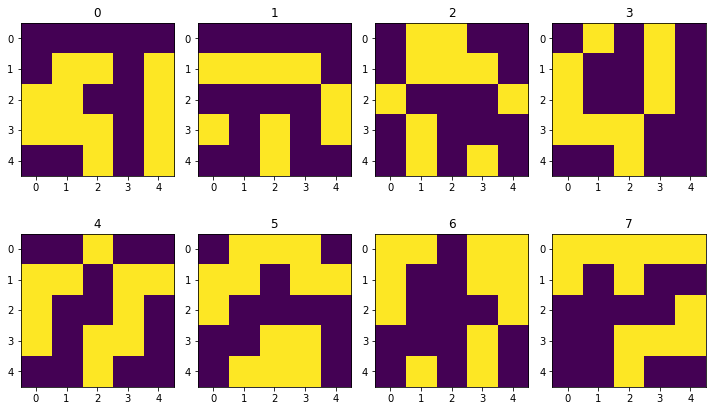

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

ca_series_5x5 = []
plot_matrix = ca_matrix_5x5

for i, ax in enumerate(axs.ravel()):
    ca_series_5x5.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_5x5 = np.array(ca_series_5x5)

plt.tight_layout()

In [5]:
ca_net_5x5 = dnet.DroughtNetwork(ca_series_5x5, name="5x5 Cellular Automata")

  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython import display
from IPython.display import HTML


In [7]:
plt.rcParams["animation.html"] = "html5"

In [8]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.invert_yaxis()
    ax.set_title(i)
    return (ax.pcolormesh(ca_series_5x5[i]),)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=8, blit=True)
video = ani.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()

In [9]:
writergif = mpl.animation.PillowWriter(fps=2)
ani.save('ca_5x5_animation.gif', writer=writergif)

what about to mp4?

writer = mpl.animation.FFMpegFileWriter(fps=2)
ani.save('ca_5x5_animation.mp4', writer=writer)

nope. that causes a pipeline error. GIF it isdata/drought/drought_impact/data

In [10]:
ani_path = '/pool0/home/steinadi/data/drought/drought_impact/animations'

ca_net_5x5.create_animated_gif(out_path=f'{ani_path}/ca_5x5_animation.gif', overwrite=True)

## Try USDM

In [11]:
import xarray as xr

In [12]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [13]:
usdm_net = dnet.DroughtNetwork(usdm['USDM'].values, name='USDM EPSG:4326')

  0%|          | 0/1163 [00:00<?, ?it/s]

In [14]:
topog, pos = usdm_net.get_nx_network()

In [15]:
temporal_cm = usdm_net.temporal_color_map()

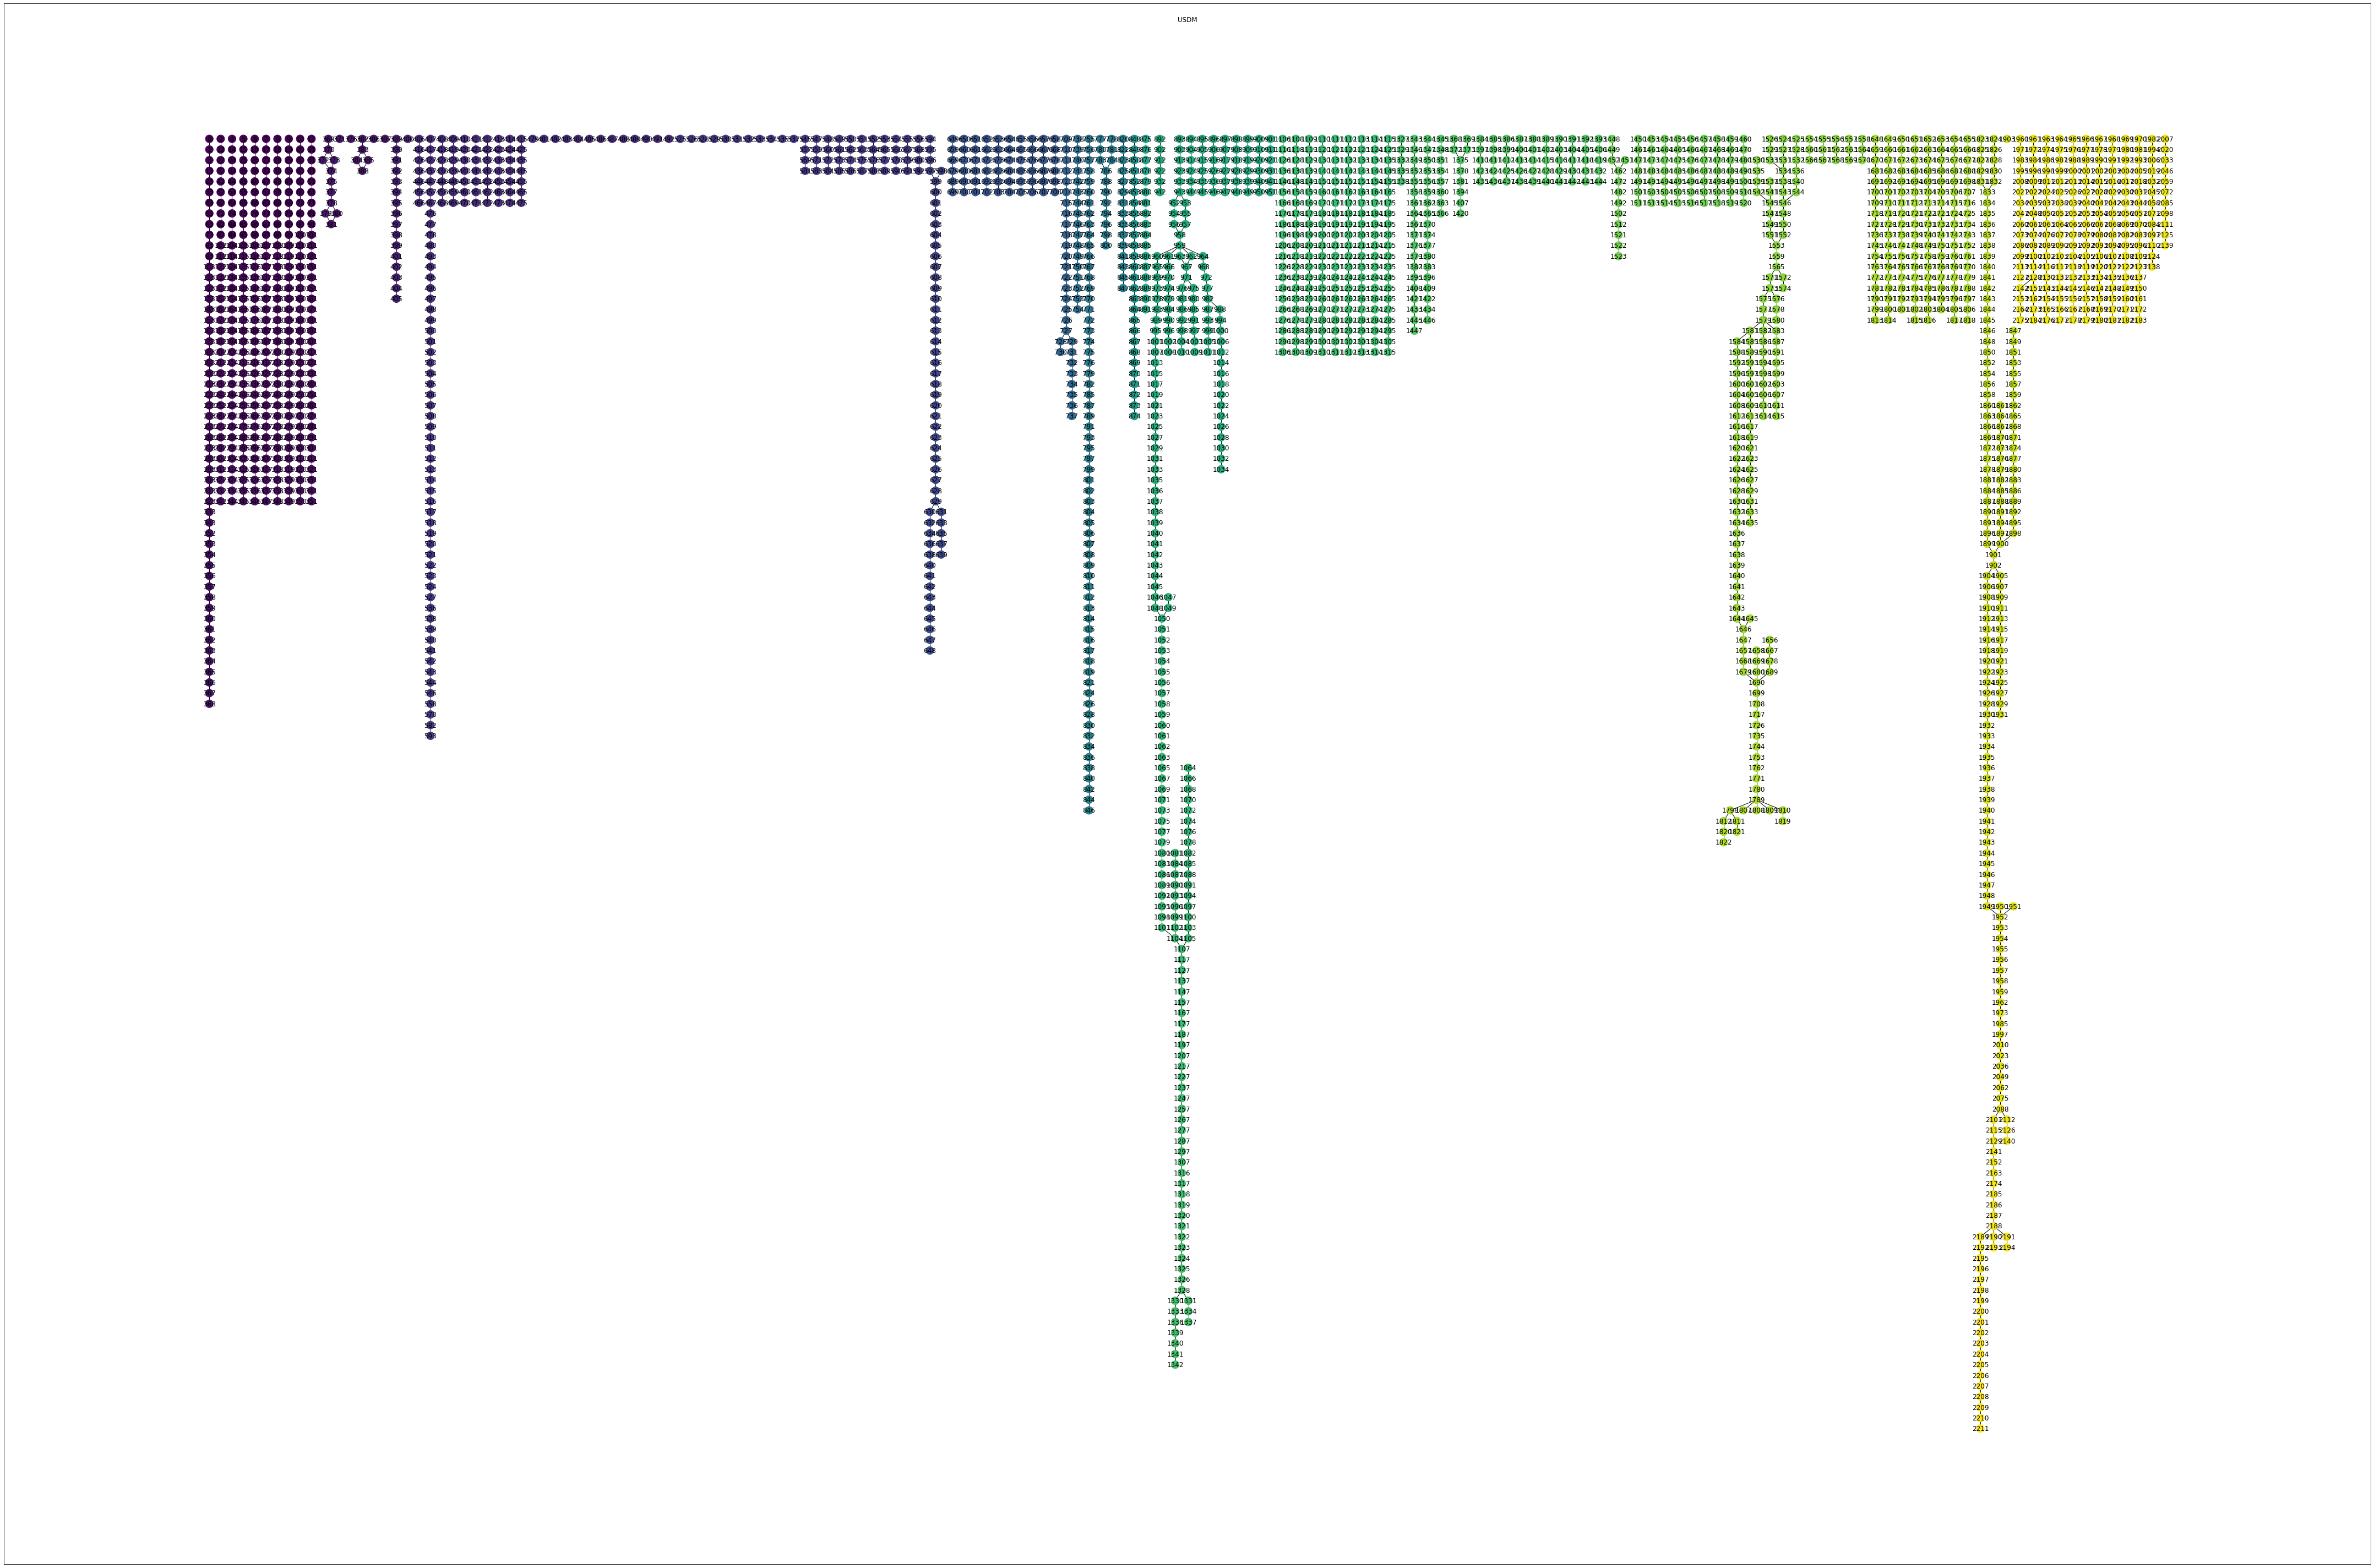

In [16]:
fig, ax = plt.subplots(figsize=(60,40))
nx.draw_networkx(topog, pos, with_labels=True, node_size=200, ax=ax, node_color=temporal_cm)
fig.suptitle('USDM')
plt.tight_layout()

In [17]:
thread = usdm_net.get_chronological_future_thread(id=893)
thread_ids = [node.id for node in thread]

In [18]:
thread_times = [node.time for node in thread]
print(thread_times[0], thread_times[-1])

731 846


In [19]:
usdm['date'].values[731]

numpy.datetime64('2014-01-07T00:00:00.000000000')

In [20]:
usdm['date'].values[846]

numpy.datetime64('2016-03-22T00:00:00.000000000')

In [21]:
adj_dict_thread = usdm_net.filter_adj_dict_by_id(thread_ids)

In [22]:
topog, pos = usdm_net.get_nx_network(adj_dict=adj_dict_thread)

In [23]:
thread_area_cm = usdm_net.relative_area_color_map(adj_dict=adj_dict_thread, cmap=plt.cm.get_cmap('viridis'))

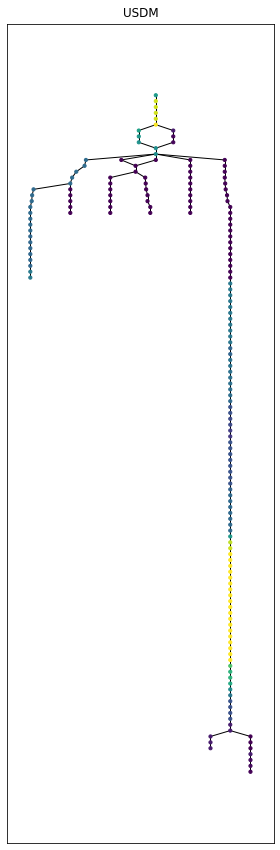

In [24]:
fig, ax = plt.subplots(figsize=(4,12))
nx.draw_networkx(topog, pos, with_labels=False, node_size=10, ax=ax, node_color=thread_area_cm)
fig.suptitle('USDM')
plt.tight_layout()

In [27]:
usdm_net.create_animated_gif(out_path=f'{ani_path}/usdm_thread_893.gif', adj_dict=adj_dict_thread, overwrite=True, fps=4)